In [ ]:
from google.colab import drive
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
#creating a connection to the database
drive.mount('/content/gdrive', force_remount=True)

path = "/content/gdrive/My Drive/Colab_Notebooks/ML/Final_Project/" 
database = path + 'database.sqlite'

conn = sqlite3.connect(database)

Mounted at /content/gdrive


In [ ]:
#geting the relevent merged data tables
def getMatchesDetails(country = """'England'""" ):
    query = """SELECT Match.id, 
                      Country.name AS country_name, 
                      League.name AS league_name, 
                      season, 
                      stage, 
                      date,
                      HT.team_long_name AS  home_team,
                      AT.team_long_name AS away_team,
                      home_team_goal, 
                      away_team_goal                                     
              FROM Match
              JOIN Country on Country.id = Match.country_id
              JOIN League on League.id = Match.league_id
              LEFT JOIN Team AS HT on HT.team_api_id = Match.home_team_api_id
              LEFT JOIN Team AS AT on AT.team_api_id = Match.away_team_api_id
              WHERE country_name =""" +country + """AND home_player_1 is not Null
              ORDER by date
              """
    return pd.read_sql(query, conn)

def getPlayersDetails():
    detailed_matches_players = pd.read_sql("""SELECT Match.id, 
                                                    date,
                                                    Country.name AS country_name, 
                                                    home_player_1, 
                                                    home_player_2,
                                                    home_player_3,
                                                    home_player_4, 
                                                    home_player_5, 
                                                    home_player_6, 
                                                    home_player_7, 
                                                    home_player_8, 
                                                    home_player_9, 
                                                    home_player_10,
                                                    home_player_11,
                                                    away_player_1,
                                                    away_player_2,
                                                    away_player_3,
                                                    away_player_4, 
                                                    away_player_5, 
                                                    away_player_6,
                                                    away_player_7,
                                                    away_player_8, 
                                                    away_player_9, 
                                                    away_player_10,
                                                    away_player_11                                       
                                            FROM Match
                                            JOIN Country on Country.id = Match.country_id
                                            WHERE country_name = 'England' AND home_player_1 is not Null
                                            """, conn)

    players = pd.read_sql("""SELECT PA.player_api_id,
                                            overall_rating, 
                                            potential
                                      FROM Player_Attributes PA 
                                      INNER JOIN Player P ON PA.player_api_id = P.player_api_id
                                      """, conn)
    return detailed_matches_players, players
  
matches = getMatchesDetails()
detailed_matches_players, players = getPlayersDetails()

detailed_matches_players.info()
players.info()
matches

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3040 entries, 0 to 3039
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              3040 non-null   int64  
 1   date            3040 non-null   object 
 2   country_name    3040 non-null   object 
 3   home_player_1   3040 non-null   int64  
 4   home_player_2   3033 non-null   float64
 5   home_player_3   3040 non-null   int64  
 6   home_player_4   3040 non-null   int64  
 7   home_player_5   3037 non-null   float64
 8   home_player_6   3040 non-null   int64  
 9   home_player_7   3035 non-null   float64
 10  home_player_8   3033 non-null   float64
 11  home_player_9   3038 non-null   float64
 12  home_player_10  3033 non-null   float64
 13  home_player_11  3039 non-null   float64
 14  away_player_1   3040 non-null   int64  
 15  away_player_2   3032 non-null   float64
 16  away_player_3   3039 non-null   float64
 17  away_player_4   3040 non-null   i

,id,country_name,league_name,season,stage,date,home_team,away_team,home_team_goal,away_team_goal
0,1730,England,England Premier League,2008/2009,1,2008-08-16 00:00:00,Arsenal,West Bromwich Albion,1,0
1,1731,England,England Premier League,2008/2009,1,2008-08-16 00:00:00,Sunderland,Liverpool,0,1
2,1732,England,England Premier League,2008/2009,1,2008-08-16 00:00:00,West Ham United,Wigan Athletic,2,1
3,1734,England,England Premier League,2008/2009,1,2008-08-16 00:00:00,Everton,Blackburn Rovers,2,3
4,1735,England,England Premier League,2008/2009,1,2008-08-16 00:00:00,Middlesbrough,Tottenham Hotspur,2,1
...,...,...,...,...,...,...,...,...,...,...
3035,4705,England,England Premier League,2015/2016,38,2016-05-15 00:00:00,Stoke City,West Ham United,2,1
3036,4706,England,England Premier League,2015/2016,38,2016-05-15 00:00:00,Swansea City,Manchester City,1,1
3037,4707,England,England Premier League,2015/2016,38,2016-05-15 00:00:00,Watford,Sunderland,2,2
3038,4708,England,England Premier League,2015/2016,38,2016-05-15 00:00:00,West Bromwich Albion,Liverpool,1,1


In [ ]:

win = 'H'
draw = 'D'
lose = 'A'

def matchResult(match):
    ''' Derives a label for a given match. '''
    #Define variables
    home_goals = match['home_team_goal']
    away_goals = match['away_team_goal']

    #Identify match label  
    if home_goals > away_goals:
        return win
    if home_goals == away_goals:
        return draw
    if home_goals < away_goals:
        return lose

def lastMatches(date, team):
    ''' Get the last matches of a given team. '''      
    #Filter last matches from team matches
    last_matches = matches[matches.date < date]

    #Filter this team matches from matches
    last_home_matches = last_matches[last_matches['home_team'] == team]
    last_away_matches =  last_matches[last_matches['away_team'] == team]

    total_num_of_matches =  last_home_matches.shape[0] + last_away_matches.shape[0] 

    #Return last matches
    return last_home_matches, last_away_matches, total_num_of_matches

def avgGoals(match, team_flag):
    ''' Get the last matches of a given team. '''
    date = match['date']
    team = match[team_flag]

    last_home_matches, last_away_matches, total_num_of_matches = lastMatches(date, team)

    home_goals = last_home_matches['home_team_goal'].sum(axis=0)
    away_goals = last_away_matches['away_team_goal'].sum(axis=0)

    if total_num_of_matches == 0:
      return 0
    return float(home_goals + away_goals) / float(total_num_of_matches)

def avgWins(match, team_flag):
    ''' Get the number of wins of a specfic team from a set of matches. '''
    date = match['date']
    team = match[team_flag]
  
    last_home_matches, last_away_matches, total_num_of_matches = lastMatches(date, team)

    #Find home and away wins
    home_wins = last_home_matches[last_home_matches.result == win ].shape[0]
    away_wins = last_away_matches[last_away_matches.result == lose ].shape[0]
    
    if total_num_of_matches == 0:
      return 0
    return (home_wins + away_wins)/total_num_of_matches
 
def lastMatchesTogether(date, home_team, away_team):
    ''' Get the last x matches of two given teams. '''
    last_matches = matches[matches.date < date]

    #Find matches of both teams
    home_matches = last_matches[(last_matches['home_team'] == home_team) & (last_matches['away_team'] == away_team)]    
    away_matches = last_matches[(last_matches['home_team'] == away_team) & (last_matches['away_team'] == home_team)]  
    total_matches = pd.concat([home_matches, away_matches])
    
    #Return data
    return total_matches

def groupsMatchStatistic(match):
    date = match['date']
    home_team = match['home_team']
    away_team = match['away_team']

    total_matches = lastMatchesTogether(date, home_team, away_team)

    if total_matches.shape[0] == 0: 
      return -1

    most_common = total_matches['result'].value_counts().idxmax()
    
    if most_common == win:
      return 1
    if most_common == draw:
      return 0  
    return 2

def teamScore(match, team_flag):
    date = match['date']
    team = match[team_flag]
    
    last_home_matches, last_away_matches, total_num_of_matches = lastMatches(date, team)

    #Find home, away wins and draws
    home_wins = last_home_matches[last_home_matches.result == win ].shape[0]
    away_wins = last_away_matches[last_away_matches.result == lose ].shape[0]
    home_draws = last_home_matches[last_home_matches.result == draw ].shape[0]
    away_draws = last_away_matches[last_away_matches.result == draw ].shape[0]

    total_wins = home_wins + away_wins
    total_draws = home_draws + away_draws

    return (total_wins*3) + total_draws 

# דירוג משוקלל של השחקנים המשתתפים בכל קבוצה 

matches['result'] = matches.apply (lambda row: matchResult(row), axis=1)
matches['home_avg_goals'] = matches.apply (lambda row: avgGoals(row, 'home_team'), axis=1)
matches['away_avg_goals'] = matches.apply (lambda row: avgGoals(row, 'away_team'), axis=1)
matches['home_avg_wins'] = matches.apply (lambda row: avgWins(row, 'home_team'), axis=1)
matches['away_avg_wins'] = matches.apply (lambda row: avgWins(row, 'away_team'), axis=1)
matches['match_common_result'] = matches.apply (lambda row: groupsMatchStatistic(row), axis=1)
matches['home_score'] = matches.apply (lambda row: teamScore(row, 'home_team'), axis=1)
matches['away_score'] = matches.apply (lambda row: teamScore(row, 'away_team'), axis=1)
matches

,id,country_name,league_name,season,stage,date,home_team,away_team,home_team_goal,away_team_goal,result,home_avg_goals,away_avg_goals,home_avg_wins,away_avg_wins,match_common_result,home_score,away_score
0,1730,England,England Premier League,2008/2009,1,2008-08-16 00:00:00,Arsenal,West Bromwich Albion,1,0,H,0.000000,0.000000,0.000000,0.000000,-1,0,0
1,1731,England,England Premier League,2008/2009,1,2008-08-16 00:00:00,Sunderland,Liverpool,0,1,A,0.000000,0.000000,0.000000,0.000000,-1,0,0
2,1732,England,England Premier League,2008/2009,1,2008-08-16 00:00:00,West Ham United,Wigan Athletic,2,1,H,0.000000,0.000000,0.000000,0.000000,-1,0,0
3,1734,England,England Premier League,2008/2009,1,2008-08-16 00:00:00,Everton,Blackburn Rovers,2,3,A,0.000000,0.000000,0.000000,0.000000,-1,0,0
4,1735,England,England Premier League,2008/2009,1,2008-08-16 00:00:00,Middlesbrough,Tottenham Hotspur,2,1,H,0.000000,0.000000,0.000000,0.000000,-1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3035,4705,England,England Premier League,2015/2016,38,2016-05-15 00:00:00,Stoke City,West Ham United,2,1,H,1.056106,1.226415,0.320132,0.301887,0,377,314
3036,4706,England,England Premier League,2015/2016,38,2016-05-15 00:00:00,Swansea City,Manchester City,1,1,D,1.227513,1.996700,0.328042,0.577558,1,237,585
3037,4707,England,England Premier League,2015/2016,38,2016-05-15 00:00:00,Watford,Sunderland,2,2,D,1.027027,1.092409,0.324324,0.257426,2,44,325
3038,4708,England,England Premier League,2015/2016,38,2016-05-15 00:00:00,West Bromwich Albion,Liverpool,1,1,D,1.147170,1.749175,0.283019,0.495050,1,297,525


In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from time import time  
from sklearn.ensemble import AdaBoostClassifier
import seaborn as sns
from sklearn.metrics import classification_report
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from matplotlib import pyplot

from numpy import arange
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2660 entries, 380 to 3039
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   home_avg_goals       2660 non-null   float64
 1   away_avg_goals       2660 non-null   float64
 2   home_avg_wins        2660 non-null   float64
 3   away_avg_wins        2660 non-null   float64
 4   match_common_result  2660 non-null   int64  
 5   home_score           2660 non-null   int64  
 6   away_score           2660 non-null   int64  
dtypes: float64(4), int64(3)
memory usage: 166.2 KB


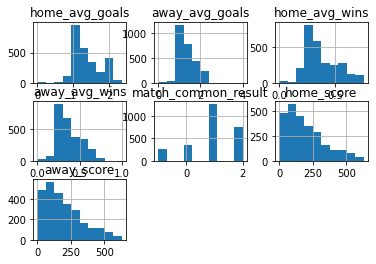

,0,1,2,3,4,5,6
0,0.177362,-1.178214,0.506426,-0.415535,1.158756,-0.927793,-1.048476
1,0.245667,1.111378,0.506426,1.039774,0.063415,-0.920859,-0.861061
2,-3.511099,-0.639487,-2.592009,-0.051708,-2.127269,-1.357689,-1.006828
3,-0.778906,0.437968,-0.769400,0.130206,0.063415,-1.073403,-1.013770
4,-0.710601,-1.178214,-0.587139,-0.961276,1.158756,-1.073403,-1.110948
...,...,...,...,...,...,...,...
2655,-0.769889,-0.329464,-0.374802,-0.511640,-1.031927,1.256356,0.818730
2656,-0.324986,1.641660,-0.320016,1.393996,0.063415,0.285623,2.699819
2657,-0.845365,-0.672379,-0.345766,-0.818987,1.158756,-1.052601,0.895084
2658,-0.533524,1.008255,-0.631844,0.823639,0.063415,0.701652,2.283342


In [ ]:
def prepareData():
  last_matches = matches[matches.season != '2008/2009']
  data = last_matches[["home_avg_goals",	"away_avg_goals",	"home_avg_wins", "away_avg_wins", "match_common_result", "home_score", "away_score"]] 
  labels = last_matches["result"] 
  return data, labels

def normalize_data(data):
    return StandardScaler().fit_transform(data)

data, labels = prepareData()
data.info()
data.hist()
plt.show()

n_data = pd.DataFrame(normalize_data(data))
n_data

In [ ]:
def confusionMatrix(y_test, y_pred):
    conf_matrix = pd.crosstab(y_test, y_pred ,rownames=['Actual'], colnames=['Predicted'])
    
    # show the confusion matrix
    ax = plt.axes()
    sns.heatmap(conf_matrix, ax=ax, linewidths=0.5, annot=True, fmt='d')
    ax.set_title('Confusion Matrix')
    plt.xlabel("Predict")
    plt.ylabel("Actual")
    plt.show()
   


def splitToTrainValdiationTest(data, labels):
    """
    split the given data and labels into random train -60%, valdiation - 30% and test - 10%.
    """
    random = 10
    #first split to train - 90% and test - 10%
    X_train_comp, X_test, y_train_comp, y_test = train_test_split(data, labels, test_size=0.1, random_state=random) 
      
    #then split the train we got to train - 60% and valdiation - 30%
    X_train, X_validation, y_train, y_validation = train_test_split(X_train_comp, y_train_comp, test_size=0.3, random_state=random) 

    return X_train, X_validation, X_test, y_train, y_validation, y_test

def trainClassifier(clf, X_train, y_train, print_stat):
    ''' Fits a classifier to the training data. '''
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train) #training
    end = time()
    
    # Print the results
    if print_stat:
      print ("Trained model in {:.4f} seconds".format(end - start))
    
def predict(clf, X_test, y_test, print_stat):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(X_test)
    end = time()
    
    # Print and return results
    if print_stat:
      print ("Made predictions in {:.4f} seconds.".format(end - start))
      confusionMatrix(y_test, y_pred)   
      print(classification_report(y_test, y_pred))
   
    score = accuracy_score(y_test, y_pred)
    return score

def trainAndPredict(clf, X_train, y_train, X_test, y_test, print_stat = True):
    ''' Train and predict using a classifer based on F1 score. '''  
    # Indicate the classifier and the training set size
    if print_stat:
      print ("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))
    
    # Train the classifier
    trainClassifier(clf, X_train, y_train, print_stat)
    0
    # Print the results of prediction for testing
    return  predict(clf, X_test, y_test, print_stat)




>c: 0.000, train: 0.454, test: 0.467
>c: 0.001, train: 0.497, test: 0.517
>c: 0.010, train: 0.515, test: 0.535
>c: 0.100, train: 0.509, test: 0.529
>c: 1.000, train: 0.510, test: 0.529
>c: 10.000, train: 0.509, test: 0.529
>c: 100.000, train: 0.509, test: 0.529
>c: 1000.000, train: 0.509, test: 0.529
Training a LogisticRegression using a training set size of 1675. . .
Trained model in 0.0217 seconds
Made predictions in 0.0016 seconds.


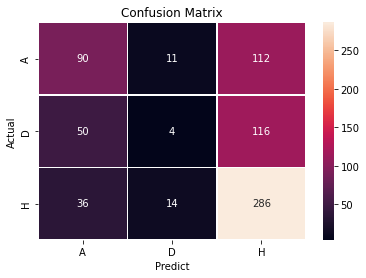

              precision    recall  f1-score   support

           A       0.51      0.42      0.46       213
           D       0.14      0.02      0.04       170
           H       0.56      0.85      0.67       336

    accuracy                           0.53       719
   macro avg       0.40      0.43      0.39       719
weighted avg       0.44      0.53      0.46       719

0.5285118219749653


In [ ]:
def optimalC(X_train, y_train, X_test, y_test, penalty = "l2"):
    """
    finding the optimal c that will give the best model.
    """
    #init
    c = 0.0001 #start with 10**-4
    c_range = 8 #num of iterations
    c_factor = 10  #multiply by 10 each iteration
    
    best_acc = 0
    best_c = 0

    for i in range(c_range):
      model = LogisticRegression(C=c, penalty=penalty, solver='lbfgs', max_iter=len(X_train)*10,
                                    multi_class='multinomial').fit(X_train, y_train) 
     	# evaluate on the train dataset
      train_pred = model.predict(X_train)
      train_acc = accuracy_score(y_train, train_pred)
 
      y_pred = model.predict(X_test)
      test_acc = accuracy_score(y_test, y_pred)
      
      # summarize progress
      print('>c: %.3f, train: %.3f, test: %.3f' % ( c, train_acc, test_acc))
     
      if test_acc > best_acc:
        best_acc = test_acc
        best_c = c
      
      c *= c_factor

    return best_c

X_train, X_validation, X_test, y_train, y_validation, y_test = splitToTrainValdiationTest(n_data, labels)

c = optimalC(X_train, y_train, X_validation, y_validation)


clf_LR = LogisticRegression(C=c, penalty="l2",
                                      max_iter=len(data)*10, class_weight = {'H':1, 'D':1.1, 'A':1},multi_class='multinomial')
 
accuracy = trainAndPredict(clf_LR, X_train, y_train, X_validation,  y_validation)
print(accuracy)


>n: 10 d: 4 r: 0.100, 0.527
>n: 10 d: 4 r: 0.200, 0.523
>n: 10 d: 4 r: 0.300, 0.508
>n: 10 d: 4 r: 0.400, 0.483
>n: 10 d: 4 r: 0.500, 0.510
>n: 10 d: 4 r: 0.600, 0.508
>n: 10 d: 4 r: 0.700, 0.495
>n: 10 d: 4 r: 0.800, 0.441
>n: 10 d: 4 r: 0.900, 0.487
>n: 10 d: 4 r: 1.000, 0.439
>n: 10 d: 4 r: 1.100, 0.446
>n: 10 d: 10 r: 0.100, 0.423
>n: 10 d: 10 r: 0.200, 0.449
>n: 10 d: 10 r: 0.300, 0.437
>n: 10 d: 10 r: 0.400, 0.437
>n: 10 d: 10 r: 0.500, 0.448
>n: 10 d: 10 r: 0.600, 0.410
>n: 10 d: 10 r: 0.700, 0.438
>n: 10 d: 10 r: 0.800, 0.466
>n: 10 d: 10 r: 0.900, 0.426
>n: 10 d: 10 r: 1.000, 0.448
>n: 10 d: 10 r: 1.100, 0.428
>n: 10 d: 50 r: 0.100, 0.399
>n: 10 d: 50 r: 0.200, 0.420
>n: 10 d: 50 r: 0.300, 0.420
>n: 10 d: 50 r: 0.400, 0.419
>n: 10 d: 50 r: 0.500, 0.416
>n: 10 d: 50 r: 0.600, 0.419
>n: 10 d: 50 r: 0.700, 0.413
>n: 10 d: 50 r: 0.800, 0.398
>n: 10 d: 50 r: 0.900, 0.414
>n: 10 d: 50 r: 1.000, 0.416
>n: 10 d: 50 r: 1.100, 0.417
>n: 10 d: 100 r: 0.100, 0.405
>n: 10 d: 100 r: 0.200, 

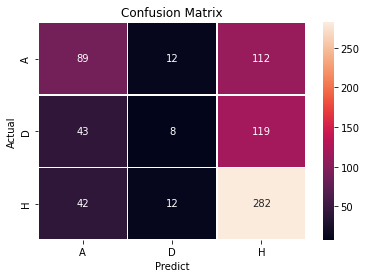

              precision    recall  f1-score   support

           A       0.51      0.42      0.46       213
           D       0.25      0.05      0.08       170
           H       0.55      0.84      0.66       336

    accuracy                           0.53       719
   macro avg       0.44      0.43      0.40       719
weighted avg       0.47      0.53      0.47       719



0.5271210013908206

In [ ]:
# get a list of models to evaluate
def get_models():
    models = dict()
    # define number of trees to consider
    n_trees = [10, 50, 100, 500]
    max_depth = [4, 10, 50, 100]
    for n in n_trees:
      for i in max_depth:
      # explore learning rates from 0.1 to 1.2 in 0.1 increments
        for j in arange(0.1, 1.2, 0.1):
            key = '%.3f' % j
            # define base model
            base = DecisionTreeClassifier(max_depth=i)
            # define ensemble model
            models['n: ' + str(n) + ' d: ' + str(i)+ ' r: ' + key] = AdaBoostClassifier(learning_rate=j, n_estimators=n, base_estimator=base)
    return models

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
best_model = {"score": 0, "name": "", "model": ""}

for name, model in models.items():
    # evaluate the model
    score = trainAndPredict(model, X_train, y_train, X_validation, y_validation, False)
    print('>%s, %.3f' % (name, score))
    
    # store the results
    results.append(score)
    names.append(name)
    # summarize the performance along the way
    if score >= best_model["score"]:
        best_model["score"] = score
        best_model["name"] = name
        best_model["model"] = model

print("Best Adaboost parameters and score:")
print(best_model["name"], best_model["score"] )
trainAndPredict(best_model["model"], X_train, y_train, X_validation, y_validation, True)


Training a AdaBoostClassifier using a training set size of 1862. . .
Trained model in 0.0847 seconds
Made predictions in 0.0046 seconds.


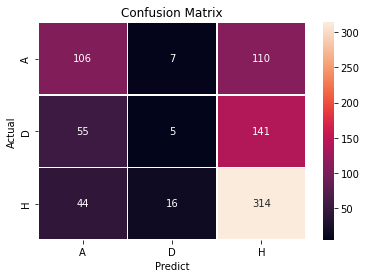

              precision    recall  f1-score   support

           A       0.52      0.48      0.50       223
           D       0.18      0.02      0.04       201
           H       0.56      0.84      0.67       374

    accuracy                           0.53       798
   macro avg       0.42      0.45      0.40       798
weighted avg       0.45      0.53      0.46       798

0.5325814536340853
Training a LogisticRegression using a training set size of 1862. . .
Trained model in 0.0292 seconds
Made predictions in 0.0016 seconds.


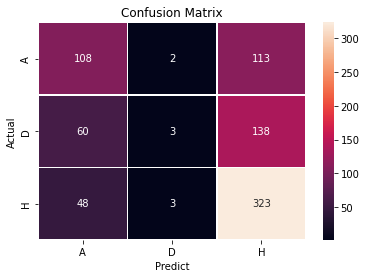

              precision    recall  f1-score   support

           A       0.50      0.48      0.49       223
           D       0.38      0.01      0.03       201
           H       0.56      0.86      0.68       374

    accuracy                           0.54       798
   macro avg       0.48      0.45      0.40       798
weighted avg       0.50      0.54      0.46       798

0.543859649122807


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(n_data, labels, test_size=0.3, random_state=10)

base = DecisionTreeClassifier(max_depth=4)
clf_ab_best = AdaBoostClassifier(learning_rate=0.2, n_estimators=10, base_estimator=base)
accuracy = trainAndPredict(clf_ab_best, X_train, y_train, X_test, y_test, True)
print(accuracy)

clf_LR_best = LogisticRegression(C=0.1, penalty="l2",
                                      max_iter=len(data)*10, multi_class='multinomial')

accuracy = trainAndPredict(clf_LR_best, X_train, y_train, X_test, y_test, True)
print(accuracy)


Training a RandomForestClassifier using a training set size of 1862. . .
Trained model in 0.4422 seconds
Made predictions in 0.0242 seconds.


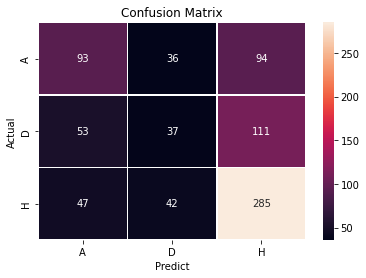

              precision    recall  f1-score   support

           A       0.48      0.42      0.45       223
           D       0.32      0.18      0.23       201
           H       0.58      0.76      0.66       374

    accuracy                           0.52       798
   macro avg       0.46      0.45      0.45       798
weighted avg       0.49      0.52      0.49       798

0.5200501253132832


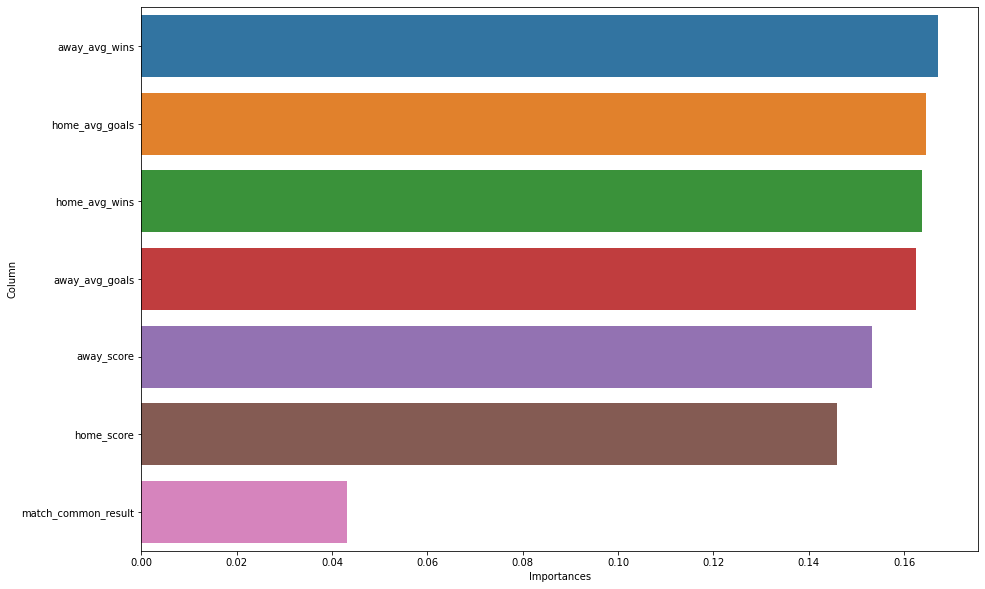

In [ ]:
clf_random = RandomForestClassifier()
accuracy = trainAndPredict(clf_random, X_train, y_train, X_test,  y_test)
print(accuracy)

importance = clf_random.feature_importances_

list_1 = []
list_2 = []
for i,j in zip(importance, data.columns):
    list_1.append(str(j))
    list_2.append(i)
    
df_name = pd.DataFrame(list_1,columns=["Column"])
df_number = pd.DataFrame(list_2,columns=["Importances"])

df_ranking = pd.concat([df_name, df_number], axis=1)
df_final = df_ranking.sort_values("Importances",ascending=False).reset_index(drop=True)
df_final.Column = df_final.Column.astype(str)
f, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x="Importances", y="Column", data=df_final)